# **Differential Expression and Marker Visualization**

This notebook explores differential gene expression and marker patterns across cell types and conditions in the single-cell COVID dataset. We preprocess metadata, visualize gene expression using PCA, UMAPs, and dot plots, and highlight genes of interest from the original paper.


In [1]:
import matplotlib.pyplot as plt
import scanpy as sc
from anndata import AnnData
import pandas as pd
import numpy as np
import seaborn as sns
import math

adata = sc.read_h5ad("../nCoV_dataset_full.h5ad")

## **Preprocessing Metadata for Downstream Analysis**

This section restores and standardizes metadata fields (`condition`, `sample_name`, `cell_type_name`) that were lost during data conversion from R. These annotations are essential for grouping and labeling in all subsequent analyses.


In [ ]:
def observe_cell_types(adata: AnnData):
    cell_type_mapping = {
        0: "Cytotoxic CD8 T cells",
        1: "Naive T cells",
        2: "NKs",
        3: "MAIT",
        4: "Activated CD4 T cells",
        5: "Naive B cells",
        6: "Plasma",
        7: "Memory B cells",
        8: "XCL+ NKs",
        9: "Cycling T cells",
        10: "Monocytes",
        11: "DCs",
        12: "Cycling Plasma",
        13: "Stem cells",
        14: "Megakaryocytes",
    }

    adata.obs["cell_type_name"] = adata.obs["cell_type"].map(cell_type_mapping)


def observe_condition(adata: AnnData):
    batch_to_condition = {
        0: "Ctrl-1",
        1: "Ctrl-2",
        2: "Ctrl-3",
        3: "IAV-1-D1",
        4: "IAV-1-D14",
        5: "IAV-2-D1",
        6: "IAV-2-D9",
        7: "COV-1-D1",
        8: "COV-1-D4",
        9: "COV-1-D16",
        10: "COV-2-D1",
        11: "COV-2-D4",
        12: "COV-2-D7",
        13: "COV-2-D10",
        14: "COV-2-D16",
        15: "COV-3-D1",
        16: "COV-3-D4",
        17: "COV-3-D16",
        18: "COV-4-D4",
        19: "COV-4-D16",
        20: "COV-5-D1",
        21: "COV-5-D7",
        22: "COV-5-D13",
    }

    adata.obs["sample_name"] = adata.obs["batch"].map(batch_to_condition)

    def categorize(sample: str):
        if sample.startswith("Ctrl"):
            return "Control"
        elif sample.startswith("COV"):
            return "COVID"
        elif sample.startswith("IAV"):
            return "IAV"
        else:
            return "Unknown"

    adata.obs["condition"] = adata.obs["sample_name"].apply(categorize)

def observe_cell_types(adata: AnnData):
    cell_type_mapping = {
        0: "Cytotoxic CD8 T cells",
        1: "Naive T cells",
        2: "NKs",
        3: "MAIT",
        4: "Activated CD4 T cells",
        5: "Naive B cells",
        6: "Plasma",
        7: "Memory B cells",
        8: "XCL+ NKs",
        9: "Cycling T cells",
        10: "Monocytes",
        11: "DCs",
        12: "Cycling Plasma",
        13: "Stem cells",
        14: "Megakaryocytes",
    }

    adata.obs["cell_type_name"] = adata.obs["cell_type"].map(cell_type_mapping)


In [4]:
observe_condition(adata)
observe_cell_types(adata)

gene_to_index = {
    gene: idx for idx, gene in enumerate(adata.raw.var["_index"].values)
}

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

## **Visualizing Global Structure with PCA**

Here we perform PCA on the log-normalized expression matrix to assess global variance across conditions and cell types. This helps in verifying batch structure and cell type separation at a high level.


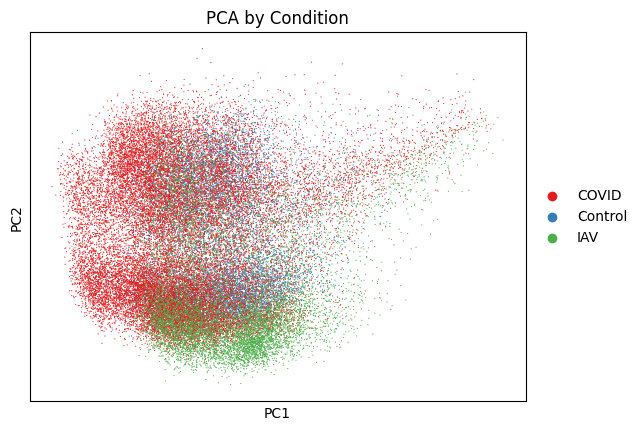

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')

palette = ["#E41A1C", "#377EB8", "#4DAF4A"]
sc.pl.pca(adata, color="condition", title="PCA by Condition", palette=palette)

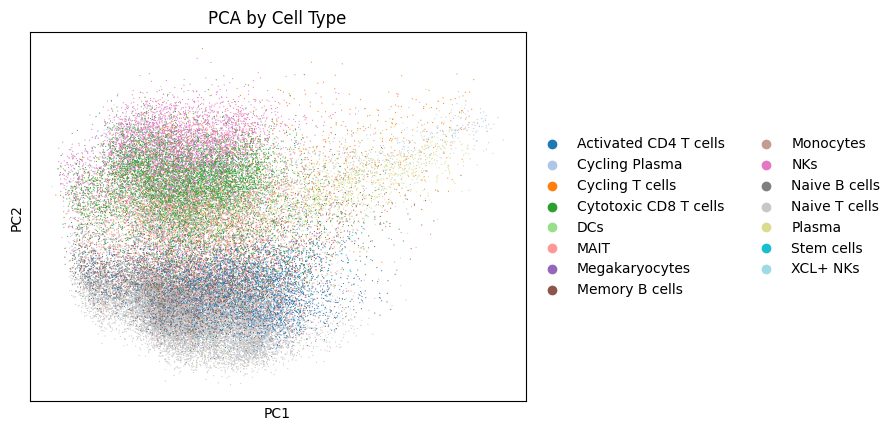

In [ ]:
sc.pl.pca(adata, color="cell_type_name", title="PCA by Cell Type", palette="tab20")

## **UMAP Embedding Highlighting Cell Types and Gene Expression**

We visualize the UMAP embedding colored by cell types and gene expression values. Gene-level coloring highlights expression patterns across the manifold, especially for genes emphasized in the original paper.


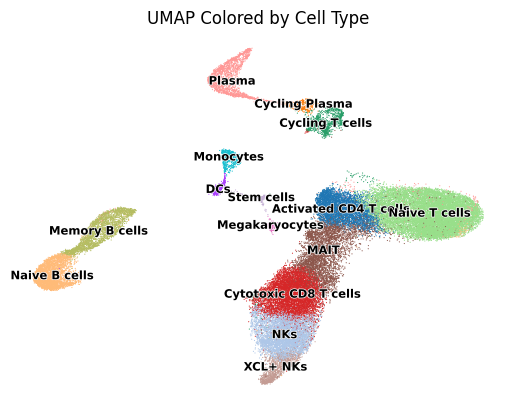

In [ ]:
sc.pl.umap(
    adata,
    color="cell_type_name",
    legend_loc="on data",
    title="UMAP Colored by Cell Type",
    frameon=False,
    legend_fontsize="small",
    legend_fontoutline=1
)

In [ ]:
genes = [
    "CNBP", "PFDN5", "BTF3", "SAP18", "ZFP36", "ZFP36L2", "IL10RB", "IL6R", "IL6ST",
    "IL27RA", "IL17RA", "IL2RA", "IL10RA", "IL7R", "IFNAR1", "TNFSF14", "STAT1", "IRF3",
    "TNFSF10", "TNF", "IL23A", "IFNG", "STAT3", "CHD1", "REL", "RUNX3", "BCLAF1", "JUND",
    "NFKB1", "PHF3", "CD69", "IL4R"
]

gene_to_index = {
    gene: idx for idx, gene in enumerate(adata.raw.var["_index"].values)
}
gene_indices = [gene_to_index[g] for g in genes]

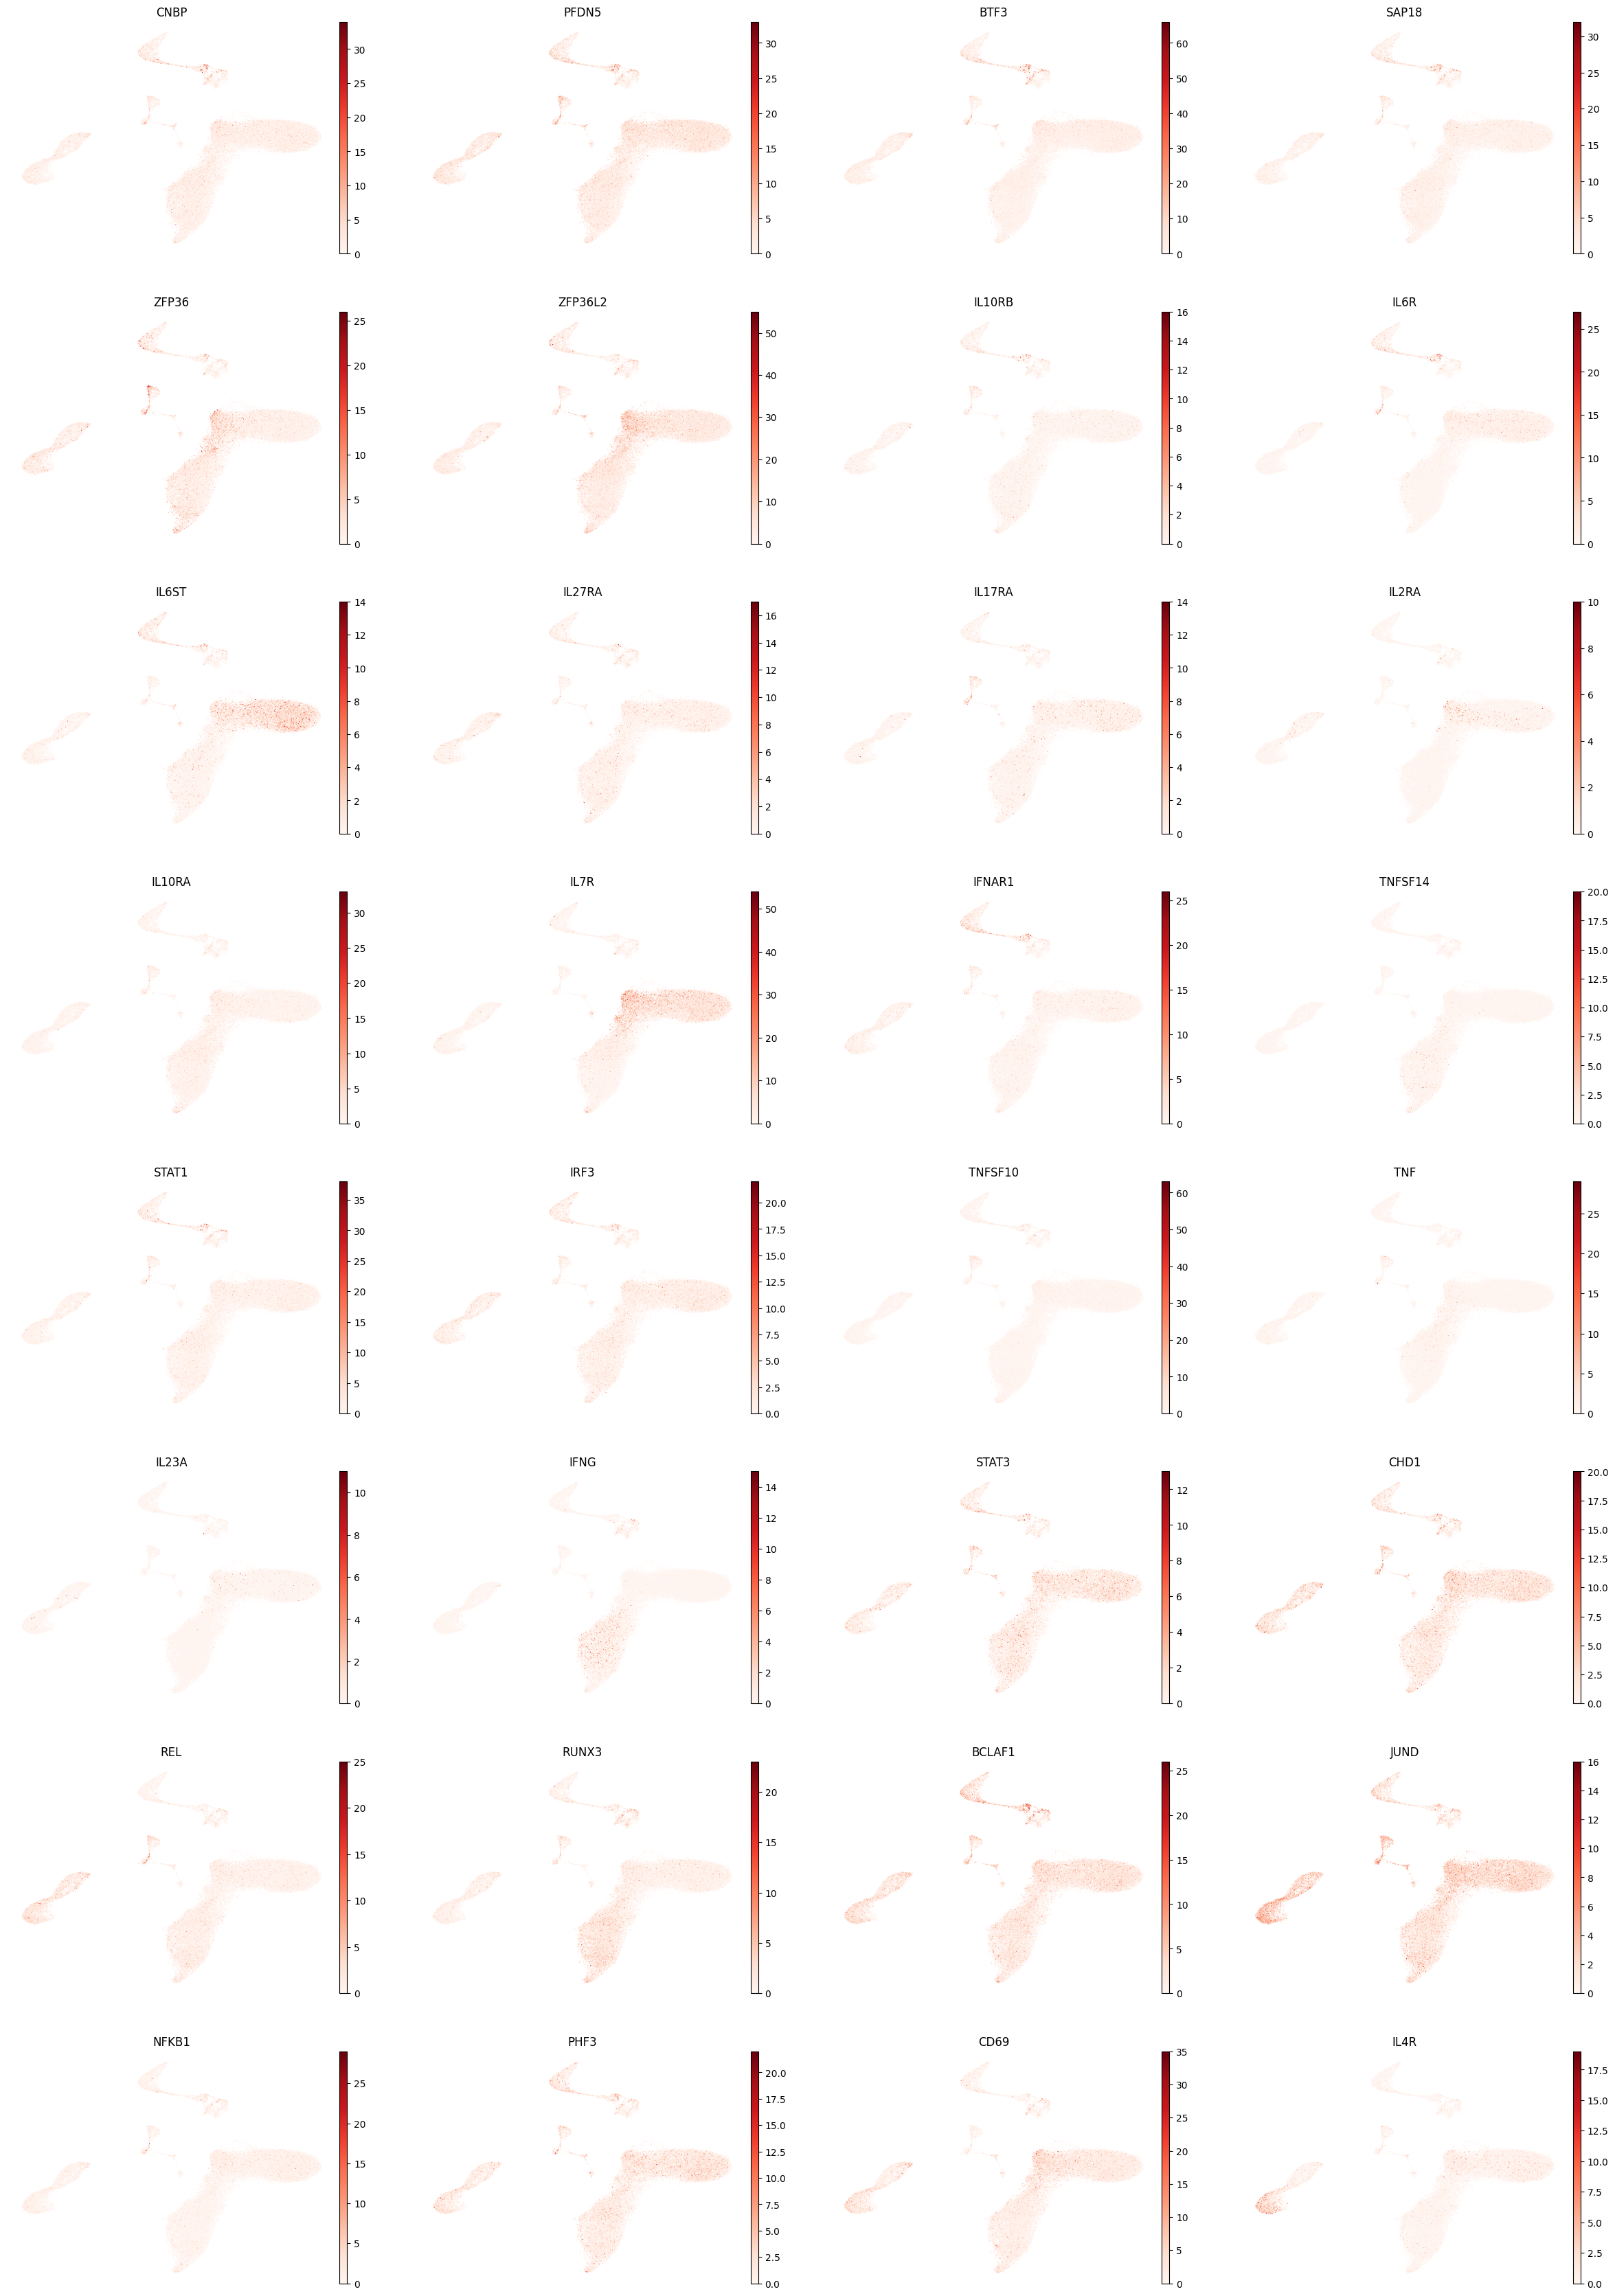

In [ ]:
sc.pl.umap(
    adata,
    color=gene_indices,
    title=[f"{g}" for g in genes],
    ncols=4,
    cmap="Reds",
    use_raw=True,
    frameon=False
)


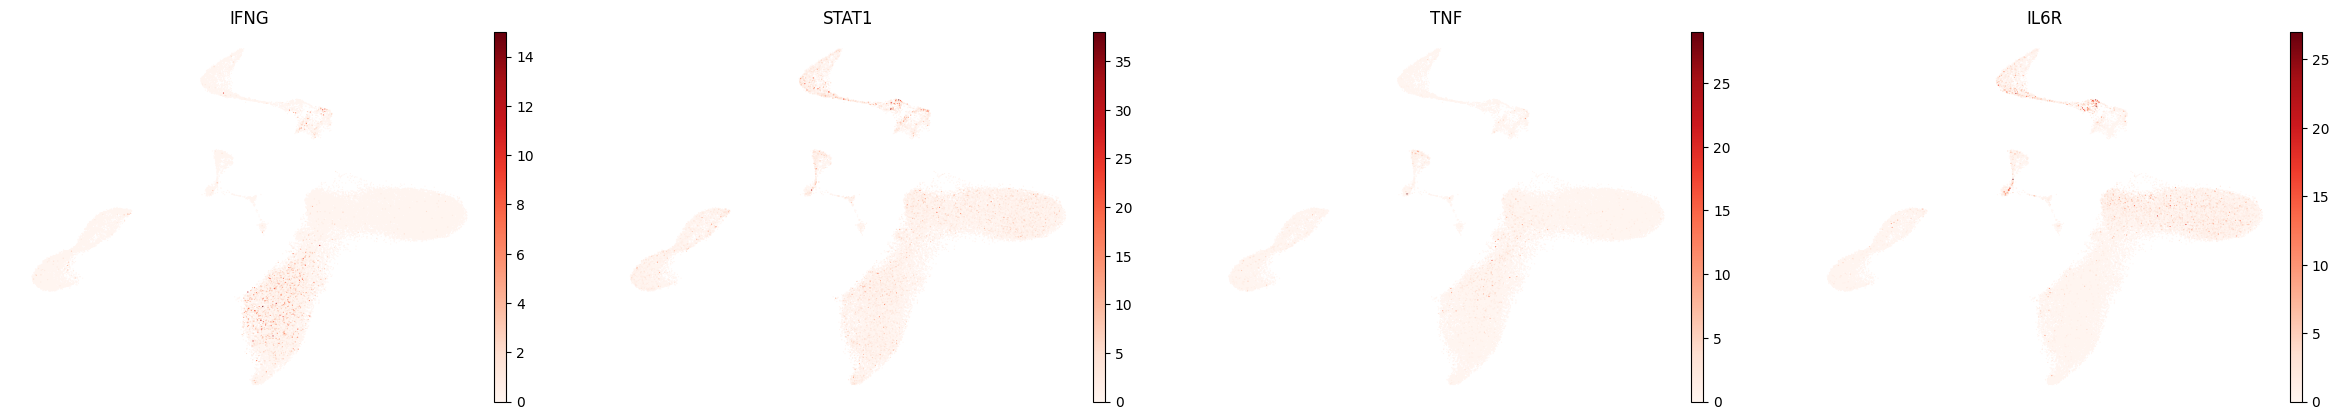

In [ ]:
# These genes are highlighted in the paper, and subsetting them makes
# the resulting plots much cleaner.
primary_genes = [
    "IFNG", "STAT1", "TNF", "IL6R",
]

primary_gene_indices = [gene_to_index[g] for g in primary_genes]

sc.pl.umap(
    adata,
    color=primary_gene_indices,        
    title=[f"{g}" for g in primary_genes],
    ncols=4,
    cmap="Reds",
    use_raw=True,
    frameon=False
)

## **Dot Plot Comparison of Marker Gene Expression Across Samples**

Dot plots summarize both the mean expression and percentage of expressing cells for select genes. These plots replicate figure panels from the original paper and provide insight into condition-specific transcriptional signatures.


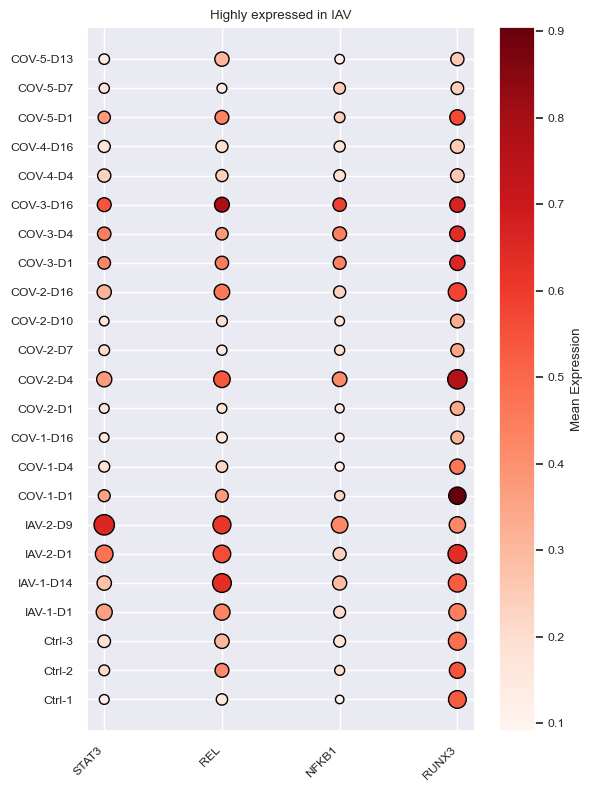

In [ ]:
# Define genes for "Highly expressed in IAV"
genes = ["STAT3", "REL", "NFKB1", "RUNX3"]

# Used to match the same order as the figure in the paper
sample_order = [
    "COV-5-D13", "COV-5-D7", "COV-5-D1",
    "COV-4-D16", "COV-4-D4",
    "COV-3-D16", "COV-3-D4", "COV-3-D1",
    "COV-2-D16", "COV-2-D10", "COV-2-D7", "COV-2-D4", "COV-2-D1",
    "COV-1-D16", "COV-1-D4", "COV-1-D1",
    "IAV-2-D9", "IAV-2-D1",
    "IAV-1-D14", "IAV-1-D1",
    "Ctrl-3", "Ctrl-2", "Ctrl-1"
]

gene_to_index = {gene: idx for idx, gene in enumerate(adata.raw.var["_index"].values)}
gene_indices = [gene_to_index[g] for g in genes]

adata_filtered = adata[adata.obs["sample_name"].isin(sample_order)].copy()
X = adata_filtered.raw[:, gene_indices].X
X = X.toarray() if hasattr(X, "toarray") else X

df_expr = pd.DataFrame(X, columns=genes)
df_expr["sample_name"] = adata_filtered.obs["sample_name"].values

plot_data = []
for sample in sample_order:
    subset = df_expr[df_expr["sample_name"] == sample]
    for gene in genes:
        mean_expr = subset[gene].mean()
        pct_expr = (subset[gene] > 0).sum() / subset.shape[0]
        plot_data.append({
            "sample": sample,
            "gene": gene,
            "mean_expr": mean_expr,
            "pct_expr": pct_expr
        })

plot_df = pd.DataFrame(plot_data)

plt.figure(figsize=(6, 8))
scatter = plt.scatter(
    x=plot_df["gene"],
    y=plot_df["sample"],
    s=plot_df["pct_expr"] * 500,
    c=plot_df["mean_expr"],
    cmap="Reds",
    edgecolors="black"
)
plt.xticks(rotation=45, ha="right")
plt.gca().invert_yaxis()
cbar = plt.colorbar(scatter)
cbar.set_label("Mean Expression")
plt.title("Highly expressed in IAV")
plt.tight_layout()
plt.show()


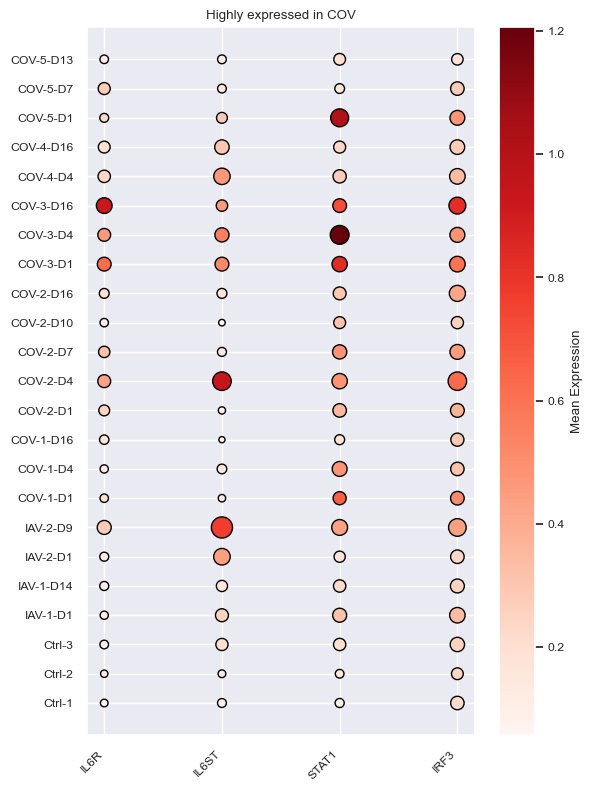

In [ ]:
# Define genes for "Highly expressed in COV"
genes = ["IL6R", "IL6ST", "STAT1", "IRF3"]

gene_to_index = {gene: idx for idx, gene in enumerate(adata.raw.var["_index"].values)}
gene_indices = [gene_to_index[g] for g in genes]

adata_filtered = adata[adata.obs["sample_name"].isin(sample_order)].copy()
X = adata_filtered.raw[:, gene_indices].X
X = X.toarray() if hasattr(X, "toarray") else X

df_expr = pd.DataFrame(X, columns=genes)
df_expr["sample_name"] = adata_filtered.obs["sample_name"].values

plot_data = []
for sample in sample_order:
    subset = df_expr[df_expr["sample_name"] == sample]
    for gene in genes:
        mean_expr = subset[gene].mean()
        pct_expr = (subset[gene] > 0).sum() / subset.shape[0]
        plot_data.append({
            "sample": sample,
            "gene": gene,
            "mean_expr": mean_expr,
            "pct_expr": pct_expr
        })

plot_df = pd.DataFrame(plot_data)

plt.figure(figsize=(6, 8))
scatter = plt.scatter(
    x=plot_df["gene"],
    y=plot_df["sample"],
    s=plot_df["pct_expr"] * 500,
    c=plot_df["mean_expr"],
    cmap="Reds",
    edgecolors="black"
)
plt.xticks(rotation=45, ha="right")
plt.gca().invert_yaxis()
cbar = plt.colorbar(scatter)
cbar.set_label("Mean Expression")
plt.title("Highly expressed in COV")
plt.tight_layout()
plt.show()


## **Violin Plots of Canonical Marker Genes by Cell Type**

This section visualizes expression distributions of key marker genes across annotated cell types, helping to validate the cell-type labeling and reveal patterns consistent with immune activation or suppression. The resulting plots relicate figures from the original paper


In [ ]:
sc.pp.scale(adata, max_value=10)

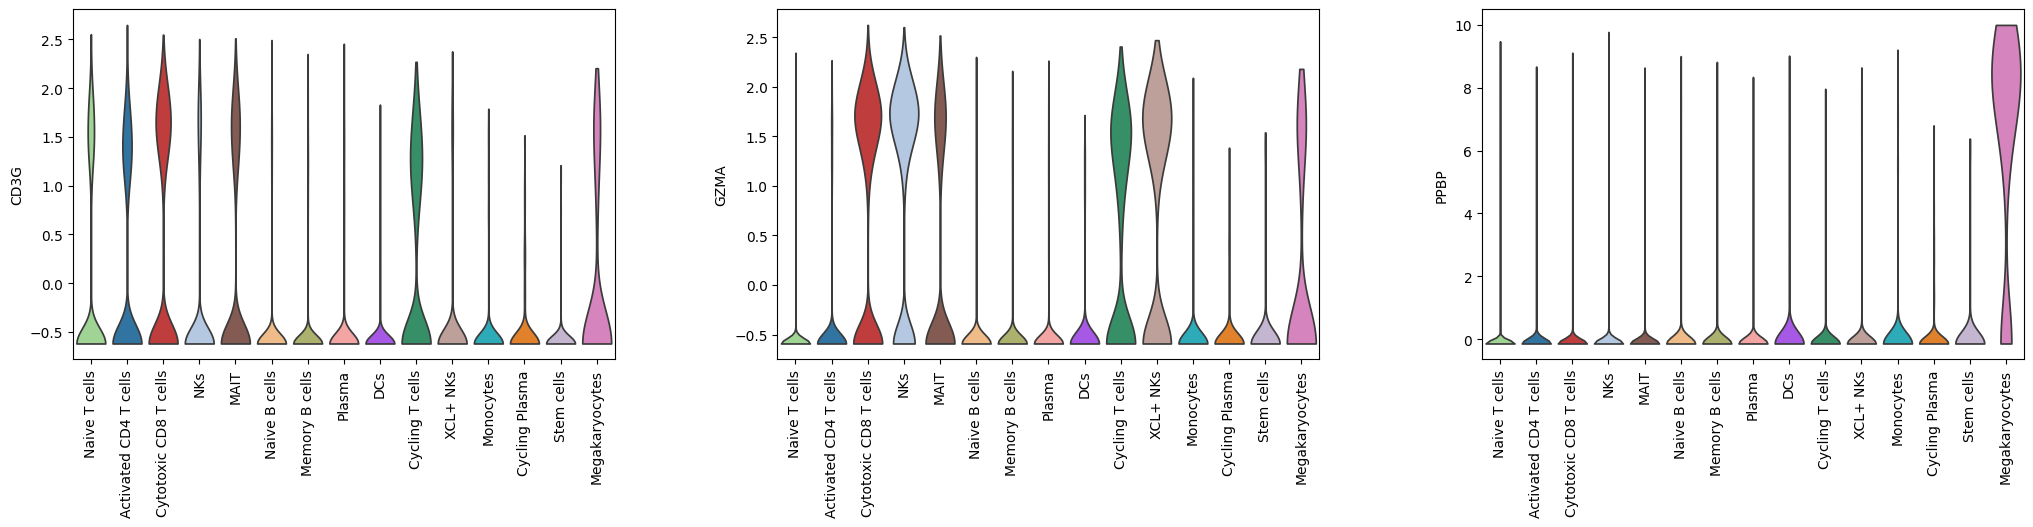

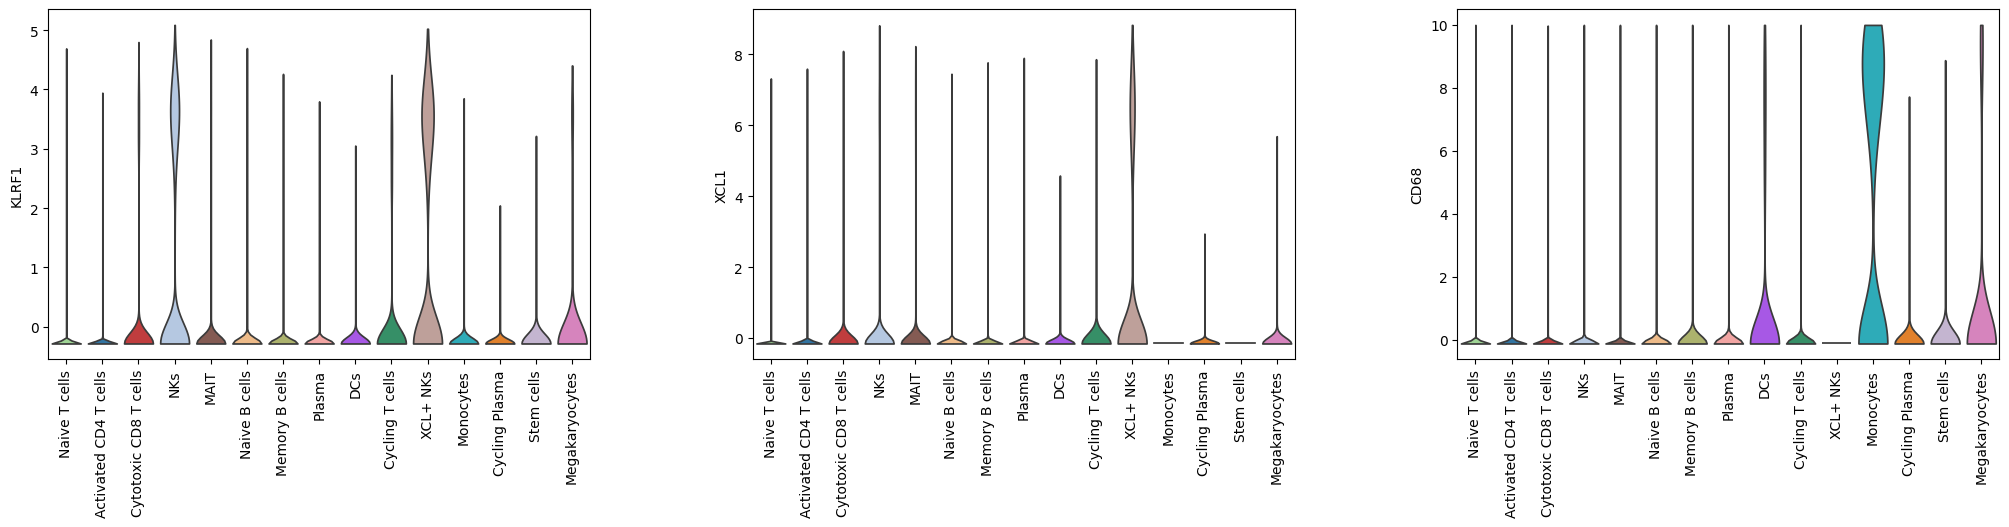

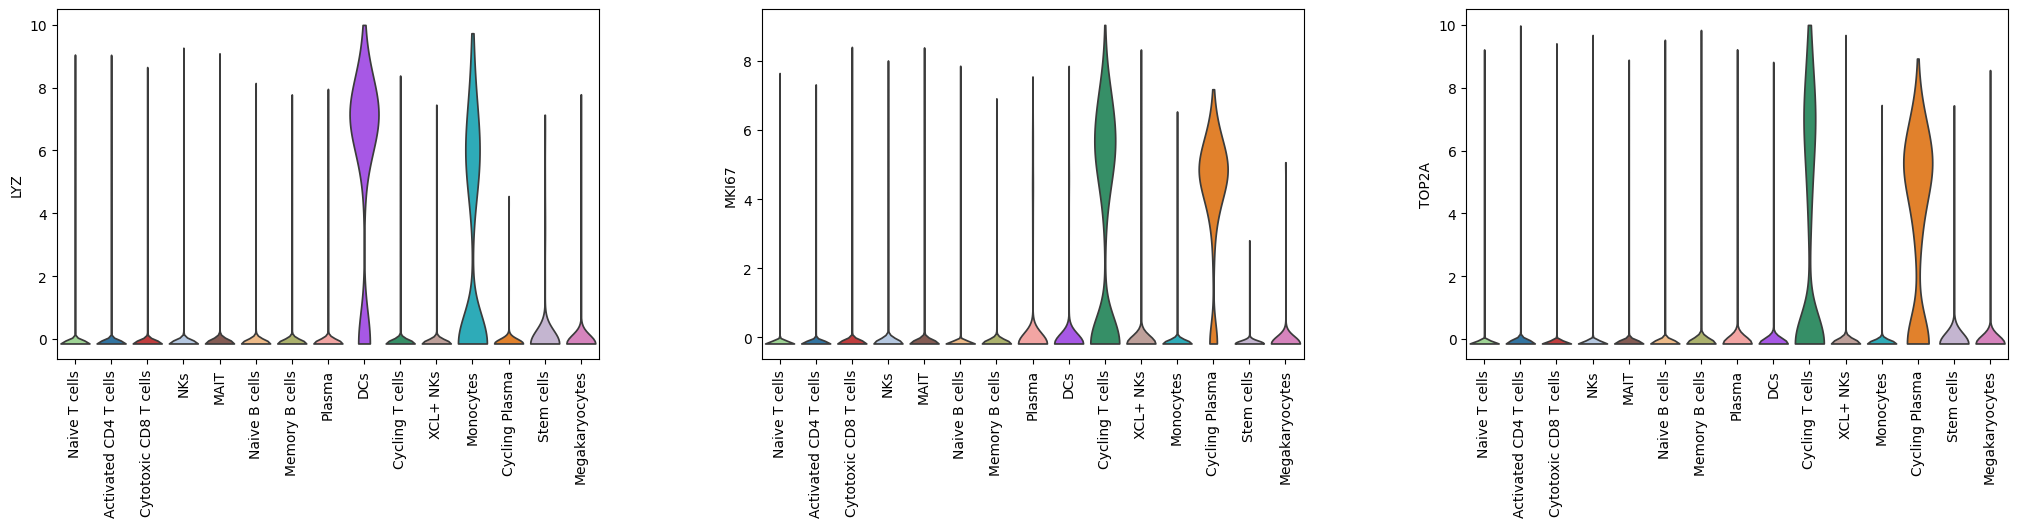

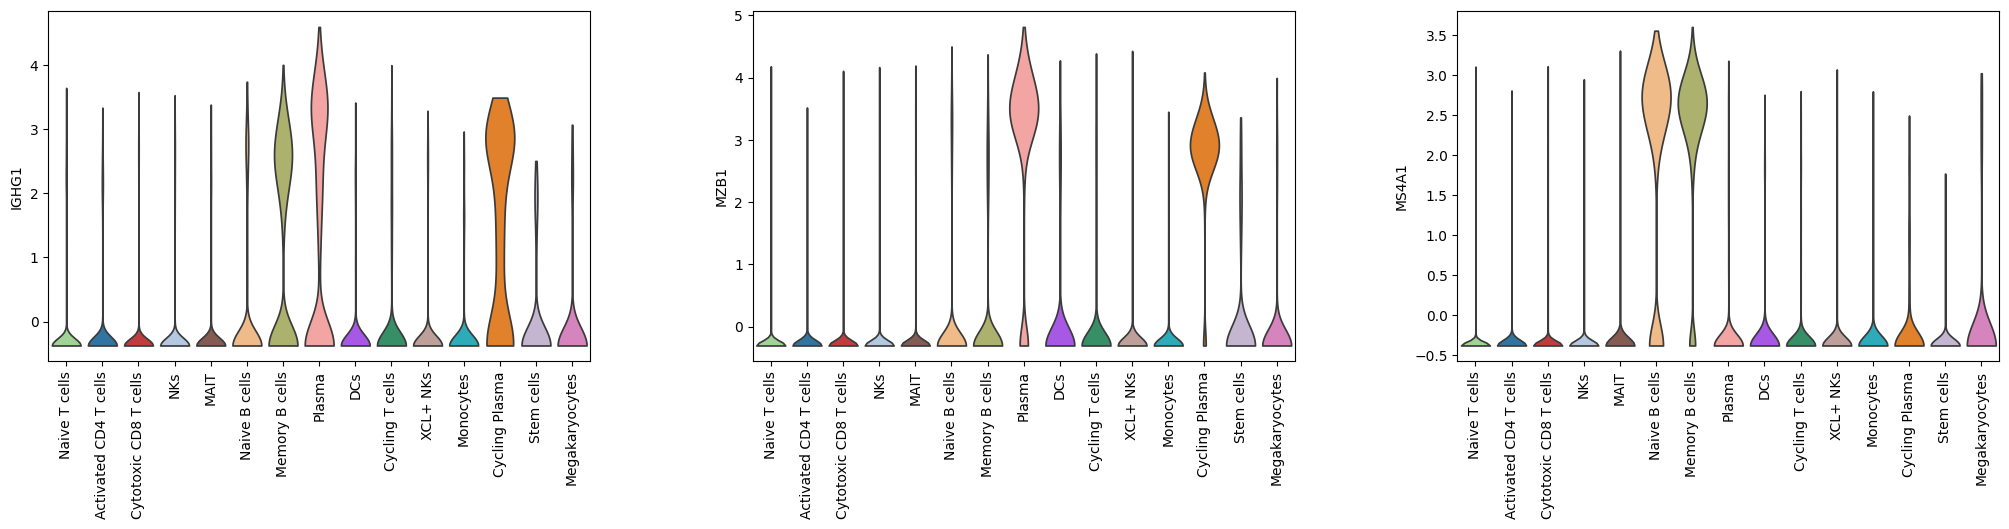

In [ ]:
marker_genes = ["CD3G", "GZMA", "PPBP", "KLRF1", "XCL1", "CD68", 
                "LYZ", "MKI67", "TOP2A", "IGHG1", "MZB1", "MS4A1"]

gene_to_index = {
    gene: idx for idx, gene in enumerate(adata.raw.var["_index"].values)
}

marker_gene_indices = [str(gene_to_index[g]) for g in marker_genes]

ncols = 3
nrows = math.ceil(len(marker_genes) / ncols)



# Plot manually in subgroups
for i in range(nrows):
    start = i * ncols
    end = (i+1) * ncols
    subset_genes = marker_genes[start:end]
    
    sc.pl.violin(
        adata,
        keys=subset_genes,
        # log=True,
        groupby="cell_type_name",
        order=[
            "Naive T cells",
            "Activated CD4 T cells",
            "Cytotoxic CD8 T cells",
            "NKs",
            "MAIT",
            "Naive B cells",
            "Memory B cells",
            "Plasma",
            "DCs",
            "Cycling T cells",
            "XCL+ NKs",
            "Monocytes",
            "Cycling Plasma",
            "Stem cells",
            "Megakaryocytes"
        ],
        stripplot=False,
        multi_panel=True,
        rotation=90,
        jitter=0.4,
        size=1.5,
        use_raw=False,
    )